# NOTEBOOK TO CHECK GAIN CORRECT ON UNALIGNED MOVIES

READ in frames from TIF movies and average.  As the frames are added they are muliplied with different GAIN images
to determine which gives the best correction.
According to this post https://groups.google.com/g/warp-em/c/-fOnQ34VMO8/m/g8d6C8T6AwAJ K2/K3 gains are multiplied to 
the raw images

In [3]:
import starfile
import mrcfile
import pandas as pd
import argparse
import os, glob, re
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import tifffile
# import ncempy.io as nio
# from ncempy.algo import rebin 

In [4]:
# input file name
glob_file = '/mnt/McQueen-001/sconnell/BREM-70S-GE81112-01182023/DATA/GridSquare_18133210/Data/*_Fractions.tiff'
n_mics = 300
n_frames = 40
fnBremGain = 'gain_bin2.mrc' # gain from BREM: dm2mrc (convert mrc) and newstack to bin
fnRelionGain = 'relion_gain.mrc'# calculated from 10K movies using relion_estimate gain
fnSeanGain = 'gain_sean.mrc' # in python read DM4 - > rebin wih mean -> set defect pixel to zero -> save MRC


In [5]:
# read in files and modify/flip as required
MrcBrem = mrcfile.open(fnBremGain, mode='r+') # unmodified BREM gain (just bined and converted as discribed above)
print (MrcBrem.data.shape)

MrcBremflr = np.fliplr(MrcBrem.data) #  BREM gain left right flip ( =x = flipped columns)
MrcBremfud = np.flipud(MrcBrem.data) # BREM gain up down flip ( =y = flipped rows )

MrcRelion = mrcfile.open(fnRelionGain, mode='r+') 
MrcSean  =  mrcfile.open(fnSeanGain, mode='r+')

In [6]:
mic_list = glob.glob(glob_file)
#print(mic_list)

In [7]:
# use float64. I get wrap around errors if  I use float32
# if I save to MRC remember to use .astype(np.float32)
# initialize zero array to accumilate running sum of frames
array_none = np.zeros((4092, 5760), dtype=np.float64)
array_brem = np.zeros((4092, 5760), dtype=np.float64)
array_bremflr = np.zeros((4092, 5760), dtype=np.float64)
array_bremfud = np.zeros((4092, 5760), dtype=np.float64)
array_relion = np.zeros((4092, 5760), dtype=np.float64)
array_sean = np.zeros((4092, 5760), dtype=np.float64)

for i in tqdm.tqdm(range(n_mics)):
    #print(mic_list[i])
    a = tifffile.imread(mic_list[i])
    for f in range(n_frames):
        # print(i,f)
        array_none += a[f]
        array_brem += (a[f]* MrcBrem.data)
        array_bremflr += (a[f] * MrcBremflr )
        array_bremfud += (a[f] * MrcBremfud )
        array_relion += (a[f] * MrcRelion.data)
        array_sean += (a[f] * MrcSean.data )


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [57:48<00:00, 11.56s/it]


In [8]:
t = n_mics*n_frames
array_none /= t
array_brem /= t
array_bremflr /= t
array_bremfud /= t
array_relion /= t
array_sean /= t

Text(0.5, 1.0, 'WITH SEAN GAIN')

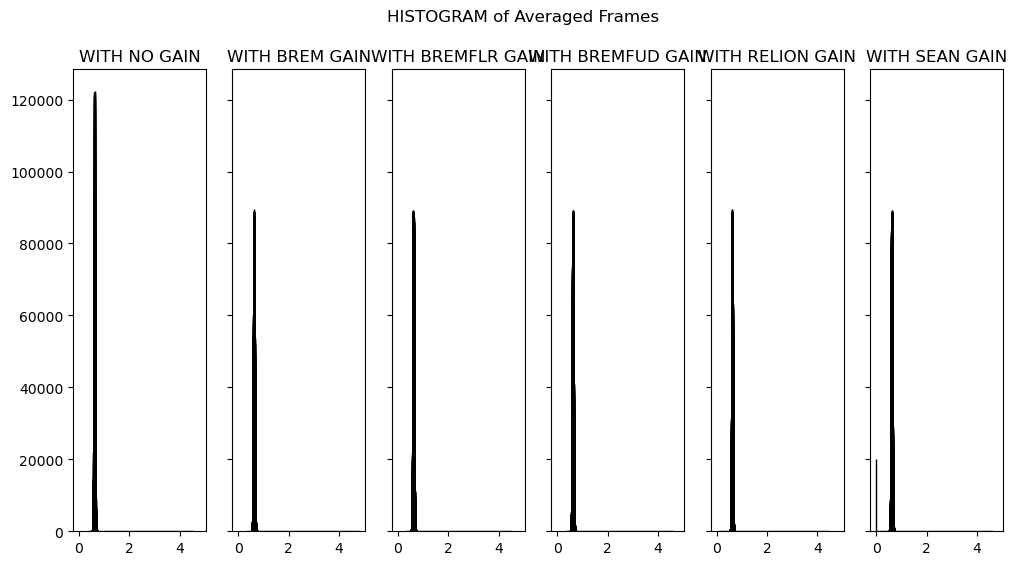

In [9]:
fig, axs = plt.subplots(1,6,sharex=True, sharey=True,figsize=(12,6))
fig.suptitle('HISTOGRAM of Averaged Frames')
axs[0].hist(array_none.ravel(), bins='auto', fc='k', ec='k')
axs[0].set_title('WITH NO GAIN')
axs[1].hist(array_brem.ravel(), bins='auto', fc='k', ec='k')
axs[1].set_title('WITH BREM GAIN')
axs[2].hist(array_bremflr.ravel(), bins='auto', fc='k', ec='k')
axs[2].set_title('WITH BREMFLR GAIN')
axs[3].hist(array_bremfud.ravel(), bins='auto', fc='k', ec='k')
axs[3].set_title('WITH BREMFUD GAIN')
axs[4].hist(array_relion.ravel(), bins='auto', fc='k', ec='k')
axs[4].set_title('WITH RELION GAIN')
axs[5].hist(array_sean.ravel(), bins='auto', fc='k', ec='k')
axs[5].set_title('WITH SEAN GAIN')

In [10]:
m_none = np.mean(array_none)
std_none = np.std(array_none)
m_brem = np.mean(array_brem)
std_brem = np.std(array_brem)
m_bremflr = np.mean(array_bremflr)
std_bremflr = np.std(array_bremflr)
m_bremfud = np.mean(array_bremfud)
std_bremfud = np.std(array_bremfud)
m_relion = np.mean(array_relion)
std_relion = np.std(array_relion)
m_sean = np.mean(array_sean)
std_sean = np.std(array_sean)

print(f' NONE (m/std): {m_none}, {std_none}' )
print(f' BREM (m/std): {m_brem}, {std_brem}' )
print(f' BREMFLR (m/std): {m_bremflr}, {std_bremflr}' )
print(f' BREMFUD (m/std): {m_bremfud}, {std_bremfud}' )
print(f' RELION (m/std): {m_relion}, {std_relion}' )
print(f' SEAN (m/std): {m_sean}, {std_sean}' )


 NONE (m/std): 0.6125778186349375, 0.021788768371636395
 BREM (m/std): 0.6172021742928248, 0.02387927030803055
 BREMFLR (m/std): 0.6171933325162795, 0.023651805855954923
 BREMFUD (m/std): 0.6172124639731137, 0.024136302326990954
 RELION (m/std): 0.6127485295151855, 0.020565948740234263
 SEAN (m/std): 0.6166664920146898, 0.030004305192255148


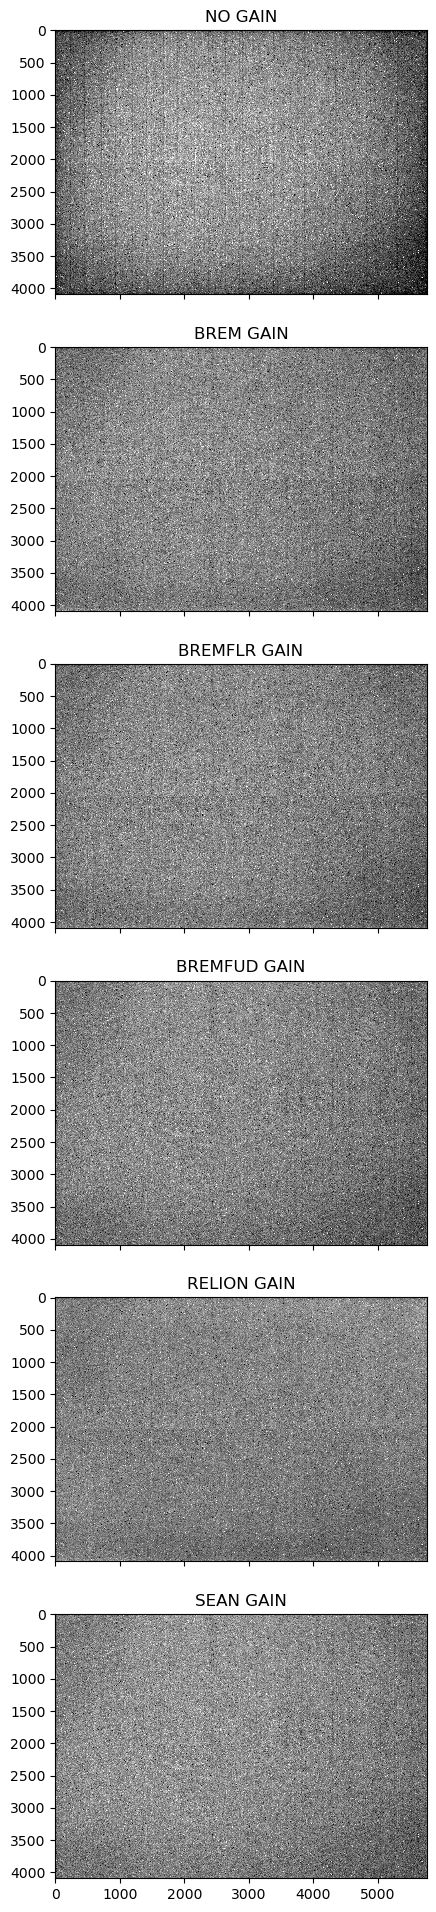

In [14]:
fig, axs = plt.subplots(nrows=6,ncols=1, sharex=True, sharey=True,figsize=(12,24))
axs[0].imshow(array_none-np.mean(array_none)+1,interpolation='none', cmap='grey', clim=(0.94, 1.06) ) 
axs[0].set_title('NO GAIN')
axs[1].imshow(array_brem-np.mean(array_brem)+1,interpolation='none', cmap='grey', clim=(0.91, 1.09) ) #clim=(0.45, 0.7)
axs[1].set_title('BREM GAIN')
axs[2].imshow(array_bremflr-np.mean(array_bremflr)+1,interpolation='none', cmap='grey', clim=(0.91, 1.09) ) #clim=(0.5, 0.7)
axs[2].set_title('BREMFLR GAIN')
axs[3].imshow(array_bremfud-np.mean(array_bremflr)+1,interpolation='none', cmap='grey', clim=(0.91, 1.09) ) #clim=(0.5, 0.7)
axs[3].set_title('BREMFUD GAIN')
axs[4].imshow(array_relion-np.mean(array_relion)+1,interpolation='none', cmap='grey', clim=(0.91, 1.09) ) #clim=(0.5, 0.7)
axs[4].set_title('RELION GAIN')
axs[5].imshow(array_sean-np.mean(array_relion)+1,interpolation='none', cmap='grey', clim=(0.91, 1.09) ) #clim=(0.5, 0.7)
axs[5].set_title('SEAN GAIN')

plt.savefig("compare_brem_relion_sean_gaincorrection.pdf", format="pdf", bbox_inches="tight")

In [ ]:
import ncempy.io as nio
from ncempy.algo import rebin 

In [ ]:
fnDmDefect = 'K3-18210046PixelDefectMap.m1.kv300.dm4'
fnDmGain = 'K3-18210046_GainRef.x1.m1.kv300.dm4'

In [ ]:
DmDefect = nio.read(fnDmDefect)
DmGain = nio.read(fnDmGain)

In [ ]:
print(DmDefect['data'].shape) # the shape of the data
print(DmDefect['pixelSize']) # print the pixel size
print(DmGain['data'].shape) # the shape of the data
print(DmGain['pixelSize']) # print the pixel size

In [ ]:
DmDefectBin = rebin(DmDefect['data'], 2, funcType='mean')
DmGainBin = rebin(DmGain['data'], 2, funcType='mean')

In [ ]:
print(DmDefectBin.shape)
print(DmGainBin.shape)

In [ ]:
m_defectbin = np.mean(DmDefectBin)
std_defectbin = np.std(DmDefectBin)
m_gainbin = np.mean(DmGainBin)
std_gainbin = np.std(DmGainBin)

print(m_defectbin)
print(std_defectbin)
print(m_gainbin)
print(std_gainbin)

In [ ]:
fnBremGain = 'gain_bin2.mrc'
MrcBrem = mrcfile.open(fnBremGain, mode='r+')
MrcBrem.data.shape
MrcBremflr = np.fliplr(MrcBrem.data)
MrcBremfud = np.flipud(MrcBrem.data)

In [ ]:
fig, axs = plt.subplots(1,2,sharex=True, sharey=True,figsize=(10,6))
fig.suptitle('HISTOGRAM of Orginal (bin2) gains')
axs[0].hist(MrcBrem.data.ravel(), bins='auto', fc='k', ec='k')
axs[0].set_title('BREM (mrc convert)')
axs[1].hist(DmGainBin.ravel(), bins='auto', fc='k', ec='k')
axs[1].set_title('BREM (DM4)')

In [ ]:
m_gaindm4bin = np.mean(DmGainBin)
std_gaindm4bin = np.std(DmGainBin)
m_gainmrcbin = np.mean(MrcBrem.data)
std_gainmrcbin = np.std(MrcBrem.data)

print(f' DM4Gain (m/std): {m_gaindm4bin}, {std_gaindm4bin}' )
print(f' MRCGain (m/std): {m_gainmrcbin}, {std_gainmrcbin}' )


In [ ]:
fig, axs = plt.subplots(nrows=1,ncols=2, sharex=True, sharey=True,figsize=(24,12))
axs[0].imshow(DmGainBin,interpolation='none', cmap='grey', clim=(0.92, 1.08) ) 
axs[0].set_title('DM4 GAIN')
axs[1].imshow(MrcBrem.data,interpolation='none', cmap='grey', clim=(0.92, 1.08) ) #clim=(0.45, 0.7)
axs[1].set_title('MRC GAIN')

In [ ]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

#https://scikit-image.org/docs/stable/api/skimage.metrics.html#

In [ ]:
mse_self = mean_squared_error(DmGainBin, DmGainBin)
ssim_self = ssim(DmGainBin, DmGainBin, data_range=DmGainBin.max() - DmGainBin.min())
diff_self = DmGainBin - DmGainBin
print(mse_self,ssim_self)

mse_brem = mean_squared_error(DmGainBin, MrcBrem.data)
ssim_brem = ssim(DmGainBin, MrcBrem.data,data_range=DmGainBin.max() - DmGainBin.min())
diff_brem = DmGainBin - MrcBrem.data
print(mse_brem,ssim_brem)

mse_bremflr = mean_squared_error(DmGainBin, MrcBremflr)
ssim_bremflr = ssim(DmGainBin, MrcBremflr,data_range=DmGainBin.max() - DmGainBin.min())
diff_bremflr = DmGainBin - MrcBremflr
print(mse_bremflr,ssim_bremflr)

mse_bremfud = mean_squared_error(DmGainBin, MrcBremfud)
ssim_bremfud = ssim(DmGainBin, MrcBremfud,data_range=DmGainBin.max() - DmGainBin.min())
diff_bremfud = DmGainBin - MrcBremfud
print(mse_bremfud,ssim_bremfud)

In [ ]:
fnDmDefect = 'K3-18210046PixelDefectMap.m1.kv300.dm4'
DmDefect = nio.read(fnDmDefect)

In [ ]:
values, counts = np.unique(DmDefect['data'],return_counts=True)
print(values)
print(counts)

In [ ]:
defects = np.where(DmDefect['data'] > 0)
print(defects[0].shape)
print(defects[1].shape)
defects

In [ ]:
values, counts = np.unique(DmDefect['data'][defects[0],defects[1]],return_counts=True)
print(values)
print(counts)

In [ ]:
DmGain = nio.read(fnDmGain)

In [ ]:
values, counts = np.unique(DmGain['data'][defects[0],defects[1]],return_counts=True)
print(values)
print(counts)

In [ ]:
temp = np.where(DmGain['data'] == 1)
print(temp[0].shape)
print(temp[1].shape)

In [ ]:
DmGain['data'][0:12,0:12]

In [ ]:
DmDefectBin = rebin(DmDefect['data'], 2, funcType='mean')
valuesbin, countsbin = np.unique(DmDefectBin,return_counts=True)
print(valuesbin)
print(countsbin)

In [ ]:
DmDefect['data'][0:12,0:12]

In [ ]:
defectsbin = np.where(DmDefectBin > 0)
defectsbin

In [ ]:
plt.imshow(DmGainBin,interpolation='none', cmap='grey', clim=(0.92, 1.08) )
plt.scatter(defectsbin[1], defectsbin[0])
plt.show()

In [ ]:
values, counts = np.unique(DmDefect['data'],return_counts=True)

In [ ]:
defects = np.where(DmDefect['data'] == 251)
defects

In [ ]:
defects_coords = list(zip(*np.where(DmDefect['data'] == 251)))
defects_coords

In [ ]:
fig, ax = plt.subplots(figsize=(12, 16))
ax.imshow(array_sum,interpolation='none', cmap='grey', clim=(0.25, 0.5))

In [ ]:
with mrcfile.new(foAvgMrc, overwrite=True) as mrc:
    mrc.set_data(array_sum)
    #mrc.set_image_stack()
    mrc.voxel_size = 1 # set with varialble todo
    mrc.update_header_from_data()

In [ ]:
MrcGain = mrcfile.open(foAvgMrc, mode='r+')
MrcGain.data.shape

In [ ]:
plt.hist(MrcGain.data.ravel(), bins='auto', fc='k', ec='k')

In [ ]:
fig, ax = plt.subplots(figsize=(18, 24))
ax.imshow(MrcGain.data,interpolation='none', cmap='grey', clim=(0.35, 0.4))

In [ ]:
fnOrigGain = 'gain_bin2.mrc'
MrcGainBrem = mrcfile.open(fnOrigGain, mode='r+')
MrcGainBrem.data.shape

In [ ]:
plt.hist(MrcGainBrem.data.ravel(), bins='auto', fc='k', ec='k')

In [ ]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(MrcGain.data,interpolation='none', cmap='grey', clim=(0.2, 0.5))
ax[1].imshow(MrcGainBrem.data,interpolation='none', cmap='grey', clim=(0.9, 1.1))

In [ ]:
m = MrcGain.data.mean()
print(m)
mo = MrcGainBrem.data.mean()
print(mo)
MrcGain_invertshift = ((MrcGain.data - m)*-1) + 1
print(MrcGain_invertshift.mean())

In [ ]:
plt.hist(MrcGain_invertshift.ravel(), bins='auto', fc='k', ec='k')

In [ ]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(MrcGain_invertshift,interpolation='none', cmap='grey', clim=(0.95, 1.04))
ax[1].imshow(MrcGainBrem.data,interpolation='none', cmap='grey', clim=(0.9, 1.1))

In [ ]:
cor= np.corrcoef(MrcGain_invertshift.flatten(), MrcGainBrem.data.flatten())
print(cor)

In [ ]:
cor= np.corrcoef(MrcGain_invertshift.flatten(), MrcGain_invertshift.flatten())
print(cor)

In [ ]:
MrcGain_invertshift_flip = np.flipud(MrcGain_invertshift)
cor= np.corrcoef(MrcGain_invertshift_flip.flatten(), MrcGain_invertshift.flatten())
print(cor)

In [ ]:
MrcGain_invertshift_flip = np.fliplr(MrcGain_invertshift)
cor= np.corrcoef(MrcGain_invertshift_flip.flatten(), MrcGain_invertshift.flatten())
print(cor)

In [ ]:
mrcfile.read(mic_list[0])

In [ ]:
a = np.array([1, 2, 3], float)
b = a

a += b

a

In [ ]:
a += b

In [ ]:
a


In [ ]:
mrc = mrcfile.open(mic_list[0], mode='r+')
mrc.data.shape

In [ ]:
mrc.data

In [ ]:
import cv2

In [ ]:
img = cv2.imread(mic_list[0], 0)

In [ ]:
img.shape